<a href="https://colab.research.google.com/github/amitnits2016/fastai/blob/master/EmergencyVsNon/EmergencyVsNon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = '/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/'

In [4]:
data = ImageDataBunch.from_folder(path, train='train_images', test='test_images',seed=1, valid_pct=0.2)

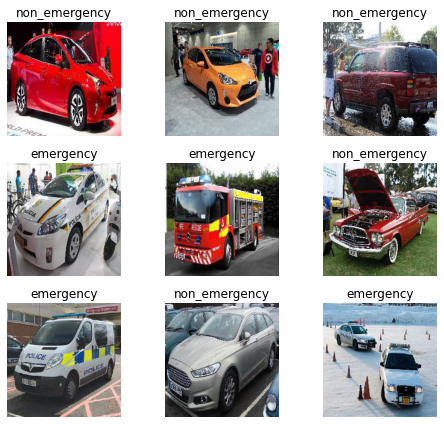

In [5]:
data.show_batch(rows=3, figsize=(7, 6))

In [6]:
print(data.classes)
len(data.classes)

['emergency', 'non_emergency']


2

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.587188,0.301873,0.091185,09:32
1,0.368845,0.261028,0.088146,00:18
2,0.263231,0.274372,0.088146,00:07
3,0.190773,0.274950,0.088146,00:07


In [10]:
learn.save('stage-1')

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

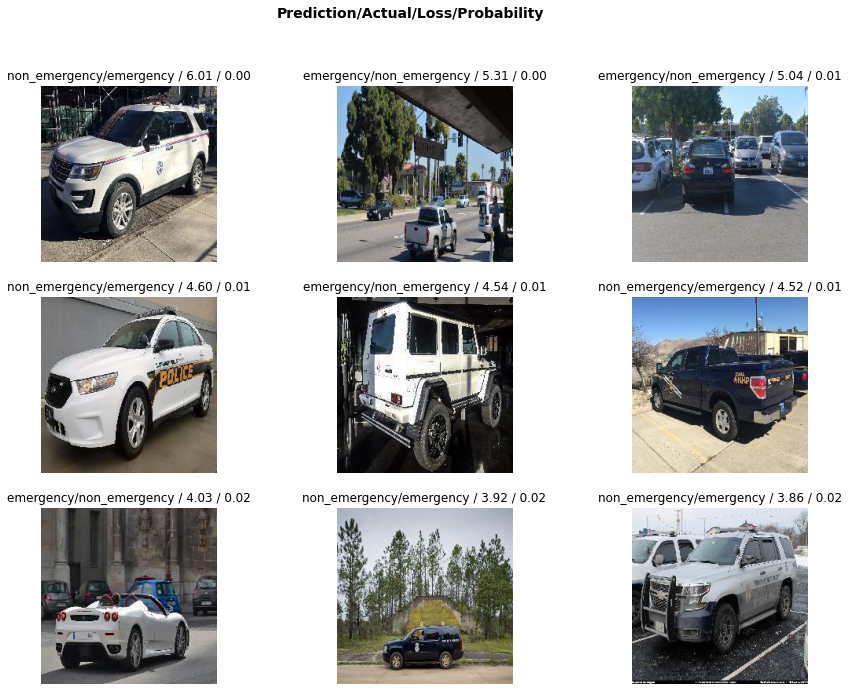

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

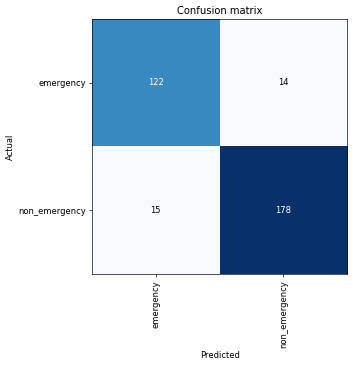

In [13]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [14]:
interp.most_confused(min_val=2)

[('non_emergency', 'emergency', 15), ('emergency', 'non_emergency', 14)]

## Unfreezing, fine-tuning, and learning rates

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.255746,0.264352,0.069909,00:08


In [17]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,emergency,emergency,emergency,emergency
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
emergency,non_emergency,non_emergency,emergency,non_emergency
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification;

Test: LabelList (706 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2)

In [1]:
learn.lr_find()

NameError: ignored

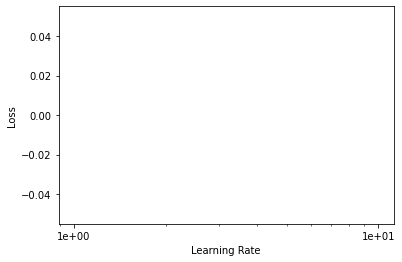

In [19]:
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.075234,0.274880,0.088146,00:09
1,0.082243,0.248381,0.088146,00:08
2,0.069610,0.245386,0.088146,00:08
3,0.066148,0.244615,0.082067,00:08
4,0.051999,0.237651,0.082067,00:08
5,0.039508,0.239924,0.082067,00:08
6,0.035929,0.233591,0.079027,00:08
7,0.028015,0.235699,0.075988,00:08
8,0.025451,0.232132,0.079027,00:08
9,0.021260,0.232317,0.075988,00:08


In [21]:
learn.freeze()
learn.save('BinaryImageClassification')

In [23]:
import pandas as pd
sub_file = pd.read_csv('/content/drive/My Drive/AAIN0896/fastai/EmergencyVSNon-Emergency_VehicalClassification/test_images_actual_label.csv')
sub_file.head()

,image_names,emergency_or_not
0,100.jpg,1
1,105.jpg,1
2,109.jpg,1
3,111.jpg,1
4,115.jpg,1


In [25]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
labels = labels.numpy()

In [26]:
sub_file['res34_preds'] = labels

In [28]:
sub_file.to_csv('submission.csv', header=True, index=False)
sub_file.head()

,image_names,emergency_or_not,res34_preds
0,100.jpg,1,0
1,105.jpg,1,1
2,109.jpg,1,1
3,111.jpg,1,0
4,115.jpg,1,1


In [47]:
sub_file['res34_diff'] = abs(sub_file['emergency_or_not'] - sub_file['res34_preds'])
sub_file.head()

,image_names,emergency_or_not,res34_preds,diff,res34_diff
0,100.jpg,1,0,1,1
1,105.jpg,1,1,0,0
2,109.jpg,1,1,0,0
3,111.jpg,1,0,1,1
4,115.jpg,1,1,0,0


In [46]:
sub_file['res34_diff'].value_counts()

1    359
0    347
Name: diff, dtype: int64

In [48]:

learn50 = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [49]:
learn50.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [50]:
learn50.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.443812,0.339148,0.088146,00:13
1,0.321383,0.329416,0.072948,00:11
2,0.223338,0.355661,0.085106,00:11
3,0.175023,0.262866,0.069909,00:11
4,0.141125,0.243798,0.069909,00:11
5,0.107847,0.253603,0.075988,00:11
6,0.079345,0.259808,0.069909,00:11
7,0.054824,0.267998,0.072948,00:11
8,0.044899,0.276023,0.072948,00:11
9,0.034267,0.272459,0.072948,00:11


In [51]:
learn50.save('stage-2')

In [55]:
interp50 = ClassificationInterpretation.from_learner(learn50)
losses50, idxs50 = interp50.top_losses()
len(data.valid_ds) == len(losses50) == len(idxs50)

True

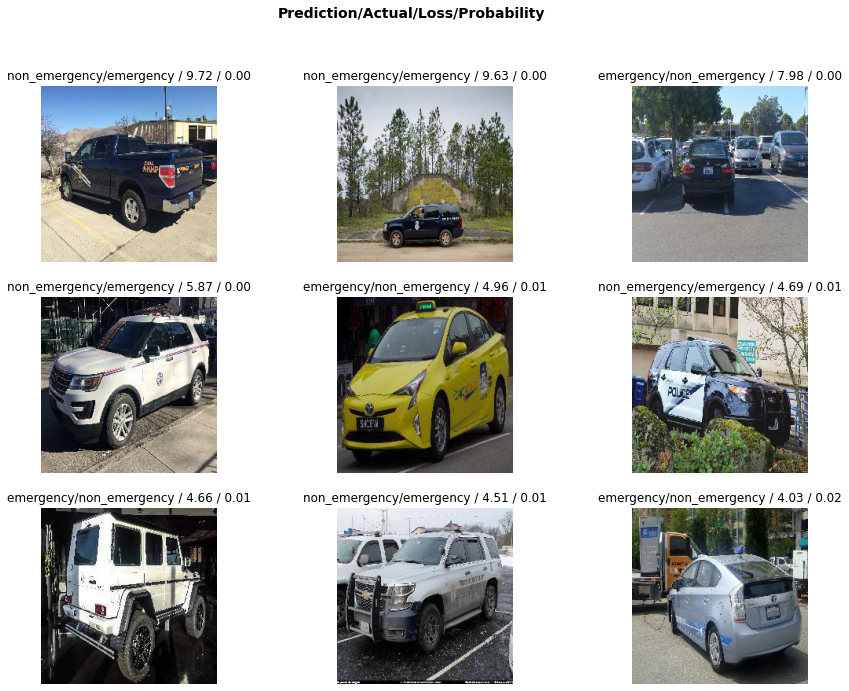

In [56]:
interp50.plot_top_losses(9, figsize=(15,11))

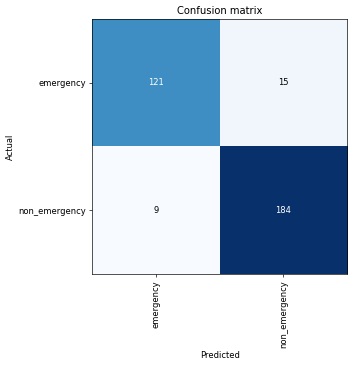

In [57]:
interp50.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [58]:
learn50.unfreeze()
learn50.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.027070,0.331158,0.072948,00:16
1,0.096787,1.181148,0.206687,00:15
2,0.153128,1.187479,0.231003,00:15
3,0.126554,0.211027,0.066869,00:15
4,0.090734,0.167380,0.039514,00:15
5,0.066283,0.201418,0.039514,00:15
6,0.049968,0.195831,0.051672,00:15
7,0.035956,0.187659,0.048632,00:15
8,0.028431,0.203696,0.054711,00:15
9,0.021623,0.193229,0.051672,00:15


In [59]:
learn50.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


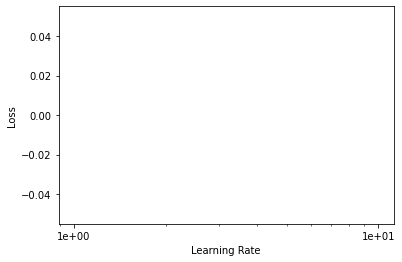

In [61]:
learn50.recorder.plot(skip_start=0, skip_end=5)